In [25]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from skl
earn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from itertools import combinations
from sklearn.cluster import KMeans

# Dataset used

Title: Resting State MRI data from healthy control (HC), Parkinson's disease with normal cognition (PD-NC), and Parkinson's disease with mild
cognitive impairment (PD-MCI) cohorts.

Description: This dataset is part of a longitudinal study investigating Parkinson's Disease (PD) and its associated cognitive impairments.
Resting-state fMRI data were collected from participants, including healthy controls (HC) and Parkinson's Disease patients with normal 
cognition (PD-NC) or mild cognitive impairment (PD-MCI). The dataset is organized following the Brain Imaging Data Structure (BIDS) specifications.

Link: https://openneuro.org/datasets/ds005892/versions/1.0.0

Aaron S. Kemp, Journey Eubank, Yahya Younus, James E. Galvin, Fred W. Prior, and Linda J. Larson-Prior (2025). Resting State MRI data from healthy 
control (HC), Parkinson's disease with normal cognition (PD-NC), and Parkinson's disease with mild cognitive impairment (PD-MCI) cohorts. 
OpenNeuro.[Dataset] doi: doi:10.18112/openneuro.ds005892.v1.0.0

Modality used: T1-weighted

Software used for segmentation: Freesurfer-7.4.1

# Load segmented volumes for all the subjects

In [3]:
df = pd.read_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/STATISTICAL_ANALYSIS/aseg_volume_all_55subjects_fixed.csv")
df

,Measure:volume,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
0,MJF001,12842.4,456.3,16465.1,63533.3,7041.6,2499.7,4941.6,2073.1,1303.4,...,623598.766963,975107.0,946841.0,1514839.0,0.810043,1.079023,27.0,21.0,48.0,1.403899e+06
1,MJF002,16340.7,432.3,13741.8,51568.0,7296.7,3483.6,4674.0,2127.0,1388.2,...,642812.460431,1048849.0,1007224.0,1710816.0,0.711177,1.032767,46.0,39.0,85.0,1.656536e+06
2,MJF003,21607.3,514.1,12331.7,49929.1,6711.6,3363.8,4442.2,1916.8,1432.1,...,676983.383439,1064404.0,1022186.0,1702981.0,0.773595,1.108687,71.0,51.0,122.0,1.536034e+06
3,MJF006,13373.1,375.2,13565.4,62681.6,7004.7,3003.5,3745.9,1650.3,1727.0,...,617098.487635,954202.0,917311.0,1623489.0,0.704888,1.036334,19.0,25.0,44.0,1.566570e+06
4,MJF007,23053.4,748.4,16166.0,66571.8,6987.6,3344.6,3790.9,1810.4,2468.5,...,727491.716230,1127061.0,1072702.0,1951242.0,0.702873,1.067279,71.0,56.0,127.0,1.828240e+06
5,MJF008,4625.7,108.2,17542.7,59948.9,7786.2,3930.9,4724.0,2126.8,1044.9,...,650843.652282,1028117.0,1014516.0,1650758.0,0.784438,1.098080,23.0,27.0,50.0,1.503313e+06
6,MJF009,9077.4,276.9,14459.4,60462.9,7082.5,3142.0,4312.0,1865.4,2327.3,...,625436.379471,976219.0,951773.0,1624924.0,0.760694,1.101642,17.0,17.0,34.0,1.475002e+06
7,MJF010,19825.3,439.2,11520.4,49900.6,6102.9,2936.7,4186.7,1960.3,1694.6,...,587103.111927,900917.0,857327.0,1367600.0,0.768355,1.027031,38.0,55.0,93.0,1.331605e+06
8,MJF011,14813.7,398.4,16955.8,57172.6,6012.8,3190.5,3730.3,1895.8,1671.8,...,634928.910728,1007907.0,974755.0,1670239.0,0.718274,1.038466,24.0,27.0,51.0,1.608371e+06
9,MJF012,25020.0,869.5,13122.4,49834.8,6458.8,3310.3,4531.3,1678.5,1947.4,...,572999.786685,913699.0,861665.0,1712558.0,0.679406,1.116085,78.0,61.0,139.0,1.534433e+06


# Normalization of Volumes w.r.t eTIV

In [4]:
def normalize_volumes_residualization(df, volume_cols, etiv_col):
    """
    Normalize brain volumes w.r.t. eTIV using residualization.
    """
    X = sm.add_constant(df[etiv_col])  # β0 + β1*eTIV
    
    df_norm = df.copy()
    
    for vol in volume_cols:
        model = sm.OLS(df[vol], X).fit()
        df_norm[f"norm_{vol}"] = model.resid
    
    return df_norm


In [7]:
volume_cols = [ 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus', 
                'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala',
                'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent',
                'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum',
                'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'Right-vessel', 'Right-choroid-plexus',
                '5th-Ventricle', 'WM-hypointensities', 'Left-WM-hypointensities', 'Right-WM-hypointensities', 'non-WM-hypointensities',
                'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities', 'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 
                'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol', 'rhCortexVol', 'CortexVol', 
                'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol', 'TotalGrayVol', 
                'SupraTentorialVol', 'SupraTentorialVolNotVent', 'MaskVol'    # add all your aseg volumes here
]

df1 = normalize_volumes_residualization(
    df,
    volume_cols,
    etiv_col="EstimatedTotalIntraCranialVol"
)


In [8]:
# df1.to_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/Normalized_volumes(smols).csv")

# Load csv with the Cognitive Status of the subjects

In [9]:
df_CognitiveStatus = pd.read_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/participants.tsv",sep = '\t') 
df_CognitiveStatus

,participant_id,group,age,sex
0,sub-MJF001,PD-MCI,68,M
1,sub-MJF002,PD-MCI,67,M
2,sub-MJF003,Control,68,M
3,sub-MJF006,Control,75,M
4,sub-MJF007,PD-MCI,77,M
5,sub-MJF008,Control,61,F
6,sub-MJF009,Control,85,F
7,sub-MJF010,PD-MCI,67,F
8,sub-MJF011,PD-NC,64,F
9,sub-MJF012,PD-MCI,81,M


In [12]:
df_CognitiveStatus.rename(columns={'participant_id': 'Subjects'}, inplace=True)
df1.rename(columns={'Measure:volume': 'Subjects'}, inplace=True)
# remove prefix
df1.columns = df1.columns.str.replace("sub-", "")

df_CognitiveStatus.columns = df_CognitiveStatus.columns.str.replace("sub-", "")
df_CognitiveStatus["Subjects"] = df_CognitiveStatus["Subjects"].str.replace("sub-", "", regex=False)


In [13]:
# Dataframe with Cognitive STatus and Normalized volumes for all the subjects

df_CS =  pd.merge(df_CognitiveStatus,df1, on=["Subjects"])
# df_CS.to_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/Normalized_volumes(smols_CS).csv")
df_CS["group"].value_counts()

group
Control    22
PD-NC      18
PD-MCI     15
Name: count, dtype: int64

In [15]:
selected_cols = [c for c in df_CS.columns if c.startswith(("norm", "Subjects", "group","age"))]
df_selected = df_CS[selected_cols]
df_selected.columns.values.tolist()

['Subjects',
 'group',
 'age',
 'norm_Left-Lateral-Ventricle',
 'norm_Left-Inf-Lat-Vent',
 'norm_Left-Cerebellum-White-Matter',
 'norm_Left-Cerebellum-Cortex',
 'norm_Left-Thalamus',
 'norm_Left-Caudate',
 'norm_Left-Putamen',
 'norm_Left-Pallidum',
 'norm_3rd-Ventricle',
 'norm_4th-Ventricle',
 'norm_Brain-Stem',
 'norm_Left-Hippocampus',
 'norm_Left-Amygdala',
 'norm_CSF',
 'norm_Left-Accumbens-area',
 'norm_Left-VentralDC',
 'norm_Left-vessel',
 'norm_Left-choroid-plexus',
 'norm_Right-Lateral-Ventricle',
 'norm_Right-Inf-Lat-Vent',
 'norm_Right-Cerebellum-White-Matter',
 'norm_Right-Cerebellum-Cortex',
 'norm_Right-Thalamus',
 'norm_Right-Caudate',
 'norm_Right-Putamen',
 'norm_Right-Pallidum',
 'norm_Right-Hippocampus',
 'norm_Right-Amygdala',
 'norm_Right-Accumbens-area',
 'norm_Right-VentralDC',
 'norm_Right-vessel',
 'norm_Right-choroid-plexus',
 'norm_5th-Ventricle',
 'norm_WM-hypointensities',
 'norm_Left-WM-hypointensities',
 'norm_Right-WM-hypointensities',
 'norm_non-WM-hy

In [16]:
# df_selected.to_csv("/mnt/c/Neuro_Parkinson/data/Cognition_Dataset/OnlyNormalized_volumes(CS).csv")

# Principal Component Analysis

In [17]:
# Define metabolites to use as features
anatomical_features = ['age', 'norm_Left-Lateral-Ventricle', 'norm_Left-Inf-Lat-Vent', 'norm_Left-Cerebellum-White-Matter', 
                       'norm_Left-Cerebellum-Cortex', 'norm_Left-Thalamus', 'norm_Left-Caudate', 'norm_Left-Putamen', 'norm_Left-Pallidum', 
                       'norm_3rd-Ventricle', 'norm_4th-Ventricle', 'norm_Brain-Stem', 'norm_Left-Hippocampus', 'norm_Left-Amygdala', 'norm_CSF',
                       'norm_Left-Accumbens-area', 'norm_Left-VentralDC', 'norm_Left-vessel', 'norm_Left-choroid-plexus',
                       'norm_Right-Lateral-Ventricle', 'norm_Right-Inf-Lat-Vent', 'norm_Right-Cerebellum-White-Matter', 
                       'norm_Right-Cerebellum-Cortex', 'norm_Right-Thalamus', 'norm_Right-Caudate', 'norm_Right-Putamen', 'norm_Right-Pallidum', 
                       'norm_Right-Hippocampus', 'norm_Right-Amygdala', 'norm_Right-Accumbens-area', 'norm_Right-VentralDC', 'norm_Right-vessel',
                       'norm_Right-choroid-plexus', 'norm_5th-Ventricle', 'norm_WM-hypointensities', 'norm_Left-WM-hypointensities',
                       'norm_Right-WM-hypointensities', 'norm_non-WM-hypointensities', 'norm_Left-non-WM-hypointensities', 
                       'norm_Right-non-WM-hypointensities', 'norm_Optic-Chiasm', 'norm_CC_Posterior', 'norm_CC_Mid_Posterior', 'norm_CC_Central',
                       'norm_CC_Mid_Anterior', 'norm_CC_Anterior', 'norm_BrainSegVol', 'norm_BrainSegVolNotVent', 'norm_lhCortexVol',
                       'norm_rhCortexVol', 'norm_CortexVol', 'norm_lhCerebralWhiteMatterVol', 'norm_rhCerebralWhiteMatterVol',
                       'norm_CerebralWhiteMatterVol', 'norm_SubCortGrayVol', 'norm_TotalGrayVol', 'norm_SupraTentorialVol',
                       'norm_SupraTentorialVolNotVent', 'norm_MaskVol']

# Extract features (metabolites) and labels (HIE vs Control)
X = df_selected[anatomical_features]
y = df_selected['group']

In [18]:
#Standardize the metabolite features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Convert scaled data back to a DataFrame (optional but useful)
X_scaled = pd.DataFrame(X_scaled, columns=anatomical_features)


In [19]:
pca = PCA(n_components=3, random_state=42)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)


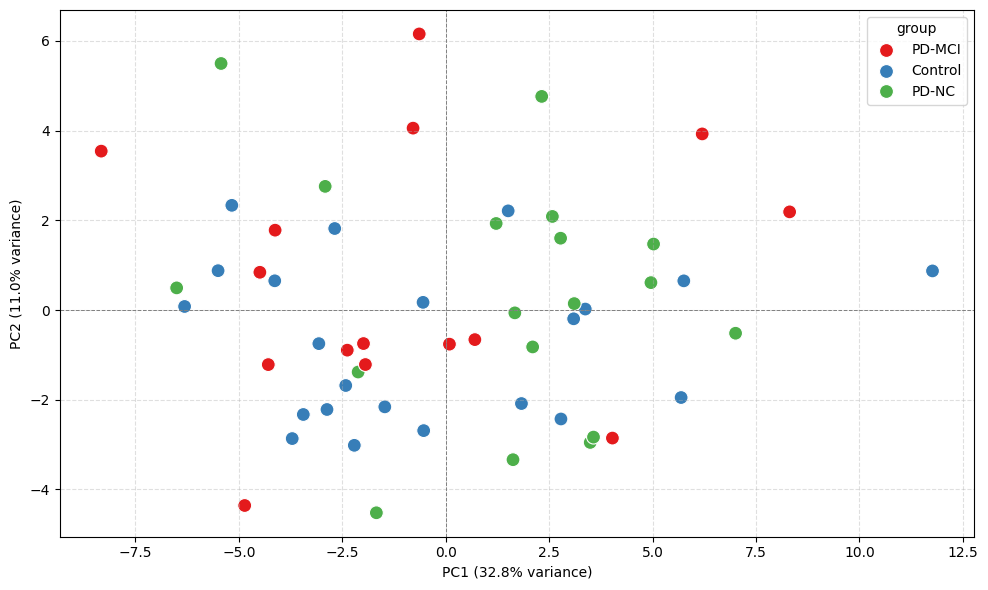

In [20]:
# Drop columns that are not features
df_clean = df_selected.drop(columns=["Subjects"], errors='ignore')

# Separate features and group labels
features = df_clean.drop(columns=['group','age'], errors='ignore')
groups = df_clean['group']

# Standardize features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA (2 components for 2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_scaled)

# Create a DataFrame with PCA components and group
pca_df = pd.DataFrame(data=pca_components, columns=["PC1", "PC2"])
pca_df['group'] = groups

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue='group', palette="Set1", s=100)
# plt.title("PCA of Honey Samples", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
# plt.savefig("PCA_clusters.png", dpi = 600)
plt.show()


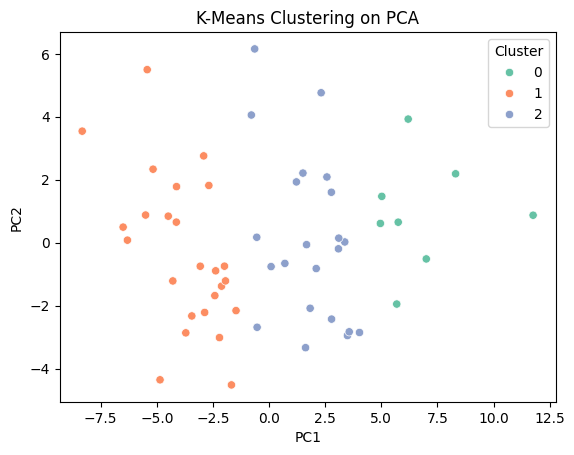

In [22]:
# Fit KMeans on your PCA components
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PC1", "PC2"]])

# Plot
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("K-Means Clustering on PCA")
# plt.savefig("Kmeansclustering_basedon_PCA.png", dpi = 600)
plt.show()
